In [1]:
from __future__ import absolute_import, division, print_function

import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import pyvirtualdisplay
import simpy

import tensorflow as tf

from tf_agents.agents.dqn import dqn_agent
from tf_agents.agents.categorical_dqn import categorical_dqn_agent
from tf_agents.networks import q_network
from tf_agents.networks import categorical_q_network

from tf_agents.policies import policy_saver
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common
from tf_agents.trajectories import time_step as ts
from tf_agents.specs import tensor_spec
#from env.RideSimulator.Grid import Grid
import tf_agents


import os,sys
sys.path.insert(1, os.path.join(sys.path[0], '..'))
from RideSimulator.taxi_sim import run_simulation
from RideSimulator import reward_parameters as rp

Loading trip data...
Data loading complete


In [2]:
#register custom env
import gym

gym.envs.register(
     id='taxi-v0',
     entry_point='env.taxi:TaxiEnv',
     max_episode_steps=1500,
     kwargs={'state_dict':None},
)

In [3]:
#hyper params

num_iterations = 30 # @param {type:"integer"}

initial_collect_steps = 1000  # @param {type:"integer"} 
collect_steps_per_iteration = 1  # @param {type:"integer"}
replay_buffer_max_length = 100000  # @param {type:"integer"}

batch_size = 64  # @param {type:"integer"}
learning_rate = 1e-3  # @param {type:"number"}
log_interval = 10  # @param {type:"integer"}

num_eval_episodes = 2  # @param {type:"integer"}
eval_interval = 5  # @param {type:"integer"}action

In [4]:
#load taxi env
env_name = "taxi-v0"
env = suite_gym.load(env_name)

tf_env = tf_py_environment.TFPyEnvironment(env)
reset = tf_env.reset()


In [5]:
#agent and policy
fc_layer_params = (100,)


q_net = q_network.QNetwork(
    tf_env.observation_spec(),
    tf_env.action_spec(),
    fc_layer_params=fc_layer_params)

optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(
    tf_env.time_step_spec(),
    tf_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

agent.initialize()


#random policy
random_policy = random_tf_policy.RandomTFPolicy(tf_env.time_step_spec(),tf_env.action_spec())

#agent policy
eval_policy = agent.policy
collect_policy = agent.collect_policy

#replay buffer
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=tf_env.batch_size,
    max_length=replay_buffer_max_length)
    
saver = policy_saver.PolicySaver(eval_policy, batch_size=None)


In [6]:

#create dataset and iterator
# Dataset generates trajectories with shape [Bx2x...]
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, 
    sample_batch_size=batch_size, 
    num_steps=2).prefetch(3)

iterator = iter(dataset)
print(iterator)

In [7]:
#catagorical dqn agent
gamma = 0.99
num_atoms = 51  # @param {type:"integer"}
min_q_value = -20  # @param {type:"integer"}
max_q_value = 20  # @param {type:"integer"}
n_step_update = 2  # @param {type:"integer"}
categorical_q_net = categorical_q_network.CategoricalQNetwork(
    tf_env.observation_spec(),
    tf_env.action_spec(),
    num_atoms=num_atoms,
    fc_layer_params=fc_layer_params)

agent = categorical_dqn_agent.CategoricalDqnAgent(
    tf_env.time_step_spec(),
    tf_env.action_spec(),
    categorical_q_network=categorical_q_net,
    optimizer=optimizer,
    min_q_value=min_q_value,
    max_q_value=max_q_value,
    n_step_update=n_step_update,
    td_errors_loss_fn=common.element_wise_squared_loss,
    gamma=gamma,
    train_step_counter=train_step_counter)
agent.initialize()

#agent policy
eval_policy = agent.policy
collect_policy = agent.collect_policy

#replay buffer
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=tf_env.batch_size,
    max_length=replay_buffer_max_length)

In [8]:
#create dataset and iterator
# Dataset generates trajectories with shape [Bx2x...]
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, 
    sample_batch_size=batch_size, 
    num_steps=n_step_update+1).prefetch(3)

iterator = iter(dataset)
print(iterator)

In [9]:
"""
policy.action(reset)
#tf_env.time_step_spec()
print(reset)
#print(env.reset())
#print(ts.restart(tf.convert_to_tensor(np.array([0,0,0,0], dtype=np.int32), dtype=tf.float32)))
print(" ")
print(ts.TimeStep(tf.constant([0]), tf.constant([0.0]), tf.constant([1.0]),tf.convert_to_tensor(np.array([[0,0,0,0]], dtype=np.int32), dtype=tf.float32)))

#print(tensor_spec.to_array_spec(reset))
#encoder_func = tf_agents.utils.example_encoding.get_example_encoder(env.reset())
#encoder_func(env.reset())
"""

#run_simulation(policy)
#ts.termination(np.array([1,2,3,4], dtype=np.int32), reward=0.0)
#ts.transition(np.array([1,2,3,4], dtype=np.int32), reward=0.0, discount=1.0)

'\npolicy.action(reset)\n#tf_env.time_step_spec()\nprint(reset)\n#print(env.reset())\n#print(ts.restart(tf.convert_to_tensor(np.array([0,0,0,0], dtype=np.int32), dtype=tf.float32)))\nprint(" ")\nprint(ts.TimeStep(tf.constant([0]), tf.constant([0.0]), tf.constant([1.0]),tf.convert_to_tensor(np.array([[0,0,0,0]], dtype=np.int32), dtype=tf.float32)))\n\n#print(tensor_spec.to_array_spec(reset))\n#encoder_func = tf_agents.utils.example_encoding.get_example_encoder(env.reset())\n#encoder_func(env.reset())\n'

In [7]:
#create a static environment for evaluation purposes

#policy that always accepts
class AcceptPolicy:
  def __init__(self):
    print("init")

  def action(self, obs):
    return (tf.constant([1]))

acceptPol = AcceptPolicy()

eval_env = run_simulation([acceptPol])
#print(eval_env)

init
hex count  114
Number of trips generated: 1883


In [8]:

#policy which accepts all positive reward trips (for evaluation purposes)
#this policy looks at pickup distance & trip distance and calculates trip reward
class AcceptPositiveTripsPolicy:
  def __init__(self):
    print("init")

  def action(self, obs):
    observations = obs.observation.numpy()[0]
    trip_reward = (observations[1] * rp.unit_reward) - ((observations[0] + observations[1]) * rp.per_km_cost)
    #print(trip_reward)
    if (trip_reward >= 0):
        return (tf.constant([1]))
    else:
        return (tf.constant([0]))

accpt_positive_trips_policy = AcceptPositiveTripsPolicy()

init


In [9]:
#evaluate a trained policy with respect to a pre-generated static environment
def evaluatePolicy(policy, eval_env):
    episode_reward = 0
    hrly_accepted_trips = np.zeros(24)
    hrly_trip_counts = np.zeros(24)
    hrly_acceptance_rates = []
    for state_list in eval_env[0]:
        states = []
        driver_reward = 0
        
        for i in range(len(state_list)):
            state_tf = ts.TimeStep(tf.constant([1]), tf.constant(state_list[i]["reward"], dtype=tf.float32), tf.constant([1.0]), tf.convert_to_tensor(np.array([state_list[i]["observation"]], dtype=np.float32), dtype=tf.float32))
            action = policy.action(state_tf)
            #action = tf.random.uniform([1], 0, 2, dtype=tf.int32)
            if (action[0].numpy() == 1):
                reward = state_list[i]["reward"]
                print(np.array([state_list[i]["observation"]]))
                hrly_accepted_trips[int(np.array([state_list[i]["observation"]])[0][2])] +=1
            else:
                reward = 0
            print (reward)
            driver_reward += reward
            hrly_trip_counts[int(np.array([state_list[i]["observation"]])[0][2])] +=1
            
            
        episode_reward += driver_reward
        print("driver reward ", driver_reward)
    print("total reward ", episode_reward)
    
    #find average acceptance for each hour
    print("trips", hrly_trip_counts )
    for j in range(24):
        hrly_acceptance_rates.append(hrly_accepted_trips[j]/hrly_trip_counts[j])
    print (hrly_acceptance_rates)

evaluatePolicy(acceptPol, eval_env)

[[12.         27.8         7.          3.83577975 41.06229257 40.        ]]
7.360000000000014
[[ 6.2    8.6    8.    15.256 31.659 39.   ]]
-14.64
[[ 4.7        26.2         8.         16.13640464  0.8165674  38.        ]]
51.880000000000024
[[12.8   22.4   12.    13.981 22.343 37.   ]]
-15.360000000000014
[[ 2.4        14.1        13.         17.51481481 10.99427292 36.        ]]
28.799999999999997
[[12.8        16.8        13.         24.29688319 34.27426219 35.        ]]
-33.28
[[ 9.7    5.6   13.    12.974 24.26  34.   ]]
-48.03999999999999
[[ 8.2        39.5        13.         51.2430783  19.32878666 33.        ]]
70.63999999999999
[[ 4.3         6.5         6.         57.07621934 17.05308593 32.        ]]
-8.439999999999998
[[ 3.         22.2        13.         45.50722993  0.6880211  31.        ]]
50.640000000000015
driver reward  89.56000000000003
[[10.2   17.6    6.    31.552 45.859 40.   ]]
-13.039999999999992
[[ 4.8         5.7        10.         27.69803746 50.91274197 39. 

-48.08000000000001
[[18.9        17.         16.          5.86735439 54.50890715 13.        ]]
-74.11999999999998
[[ 5.6   35.2   17.    11.071 20.298 12.   ]]
74.56
[[18.7        21.         17.         11.48632448 57.77970738 11.        ]]
-59.960000000000036
[[12.         11.1        17.          6.14737125 44.22462759 10.        ]]
-46.08000000000001
[[ 7.6        15.6        17.         18.12848856 24.640352    9.        ]]
-1.759999999999991
[[ 6.6        13.8        17.         38.31561294 25.21450498  8.        ]]
-0.7199999999999989
[[ 8.8        30.          1.          5.21230522 14.4900728   7.        ]]
36.160000000000025
[[ 3.3        35.7         6.         22.97654486 46.50808245  6.        ]]
91.80000000000001
[[10.4    8.     6.    12.175 48.895  5.   ]]
-45.11999999999999
[[10.3        19.1         7.         13.71454456 36.75964686  4.        ]]
-8.920000000000016
[[ 4.5         8.2         7.          9.73894675 36.14430421  3.        ]]
-4.359999999999999
[[ 8.1  

[[13.1       17.4       15.        23.7989717 48.2022819 36.       ]]
-33.400000000000006
[[ 5.9    2.5   16.    20.621 41.999 35.   ]]
-32.12
[[ 3.5        23.6        16.         31.53379354 24.97085848 34.        ]]
51.72
[[11.6        18.1        17.          2.97921787 22.37542152 33.        ]]
-20.960000000000008
[[ 6.8        17.5        17.         22.83417281 33.95370701 32.        ]]
9.759999999999991
[[23.3        13.         18.         17.69868807 45.82650856 31.        ]]
-116.83999999999997
[[10.5         8.4        18.          4.21055433 51.59410542 30.        ]]
-44.51999999999998
[[ 3.1        32.         18.         18.13226745 20.46507549 29.        ]]
81.32
[[13.3        19.6        18.         22.8860485   0.18657029 28.        ]]
-27.720000000000027
[[26.7        12.1        18.         16.50990248 15.24791443 27.        ]]
-142.83999999999997
[[ 7.6   11.4   19.     6.696 25.524 26.   ]]
-15.199999999999989
[[ 7.8    6.9   19.     9.09  35.503 25.   ]]
-30.9599

[[ 2.9    3.3    7.    20.95  20.669 24.   ]]
-9.159999999999997
[[13.4         8.9         8.         10.88842914 37.81500033 23.        ]]
-62.640000000000015
[[ 5.8        13.4         8.         15.71942269 43.64156333 22.        ]]
3.4399999999999977
[[13.9         2.          8.          4.3101041  32.72194924 21.        ]]
-88.12
[[ 4.3        11.2         9.         15.82809018 39.67156649 20.        ]]
6.6000000000000085
[[ 9.6        13.          9.         22.24549453 45.0906087  19.        ]]
-23.680000000000007
[[ 6.2         3.4        10.         13.18957055 44.18789514 18.        ]]
-31.28
[[ 3.     4.7   10.     7.016 41.531 17.   ]]
-5.359999999999999
[[ 3.6         3.7        10.          7.58821432 45.32530037 16.        ]]
-12.64
[[12.4         5.7        12.          5.05354606 38.96407582 15.        ]]
-66.08000000000001
[[11.1        18.2        12.         16.28312799 12.557696   14.        ]]
-17.23999999999998
[[15.8         5.6        12.         11.9443792 

[[13.5         8.4        21.         18.1484957  42.12482824 16.        ]]
-64.91999999999999
[[ 0.3        24.7        21.         21.93661345 17.64154212 15.        ]]
77.0
[[10.4         9.5         6.          4.42901589 13.0427061  14.        ]]
-40.31999999999999
[[ 3.5   16.6    7.     2.745 28.565 13.   ]]
29.319999999999993
[[ 3.7        13.4         7.         10.33556274 43.22412222 12.        ]]
17.72
[[16.         11.2         7.          8.74610958 48.07043707 11.        ]]
-72.95999999999998
[[14.1       41.5        7.        28.5110242 28.7607304 10.       ]]
36.920000000000016
[[14.8   19.8    8.     1.534 46.867  9.   ]]
-37.28
[[12.9        12.          8.         21.75934267 45.12619394  8.        ]]
-49.31999999999999
[[10.9         9.1         8.         13.76977052 50.42753072  7.        ]]
-45.0
[[ 3.6         3.          8.          9.73516535 55.5441981   6.        ]]
-14.879999999999995
[[ 5.9         2.5         8.          6.22015671 57.41059391  5.       

[[ 5.8   18.9   16.    48.797 30.848 32.   ]]
21.04000000000002
[[ 2.8        20.8        13.         53.20908275 52.82245507 31.        ]]
47.51999999999998
[[ 1.6        36.         18.         17.08223458 46.98393918 30.        ]]
104.32
[[ 6.4        14.7        18.          2.22788133 58.54045757 29.        ]]
3.519999999999982
[[13.6        22.1        18.         21.43423475 32.63335022 28.        ]]
-21.76000000000002
[[14.3         7.2        19.          1.56455038 38.57009889 27.        ]]
-74.19999999999999
[[ 8.7        19.6        19.         18.94729538 42.98963576 26.        ]]
3.5600000000000023
[[11.6   14.9   19.     6.599 43.196 25.   ]]
-31.19999999999999
[[ 8.2        11.3        19.          8.66006903 23.81129269 24.        ]]
-19.599999999999994
[[ 2.4        15.5        19.         20.56766906 35.68329314 23.        ]]
33.280000000000015
[[14.2        39.3        19.         39.04111707 56.09788348 22.        ]]
29.19999999999999
[[ 9.9        20.1        20. 

[[ 5.2        20.9        15.         22.22725731 52.92394288 -1.        ]]
31.52000000000001
[[23.3        22.3        16.         25.95444963 46.18130573 -1.        ]]
-87.07999999999998
[[22.1         1.4        16.          4.66795679 36.81838528 -1.        ]]
-145.79999999999998
[[ 8.1    2.    16.     9.214 45.532 -1.   ]]
-48.67999999999999
[[18.9   26.4   16.     6.249  3.054 -1.   ]]
-44.039999999999964
[[17.3         4.1        16.         17.54062784 10.77733581 -1.        ]]
-104.51999999999998
[[20.         29.2        16.         16.30363509 53.28576703 -1.        ]]
-42.56
[[ 7.         12.1        17.         20.84296405 46.94787847 -1.        ]]
-8.879999999999995
[[17.9         5.7        17.          3.99878529 36.87976085 -1.        ]]
-103.47999999999999
[[12.4        16.1        17.         20.85380544 45.84395918 -1.        ]]
-32.79999999999998
[[21.2        15.5        17.          8.45671444 44.39088347 -1.        ]]
-94.56
[[10.7    5.7   17.     5.084 38.556

[[ 6.4        35.2        11.         36.56556828 34.49383463 -1.        ]]
69.12
[[18.1        23.         13.         47.39243885 19.77458608 -1.        ]]
-49.48000000000002
[[ 4.7        18.8        19.         48.79546565 43.16015237 -1.        ]]
28.200000000000017
[[ 2.4        15.5        20.         36.69117903 50.23191154 -1.        ]]
33.280000000000015
[[ 5.8        31.3        21.         16.70592643 19.06634151 -1.        ]]
60.72
[[15.5         7.3        21.          1.5487884  29.84843493 -1.        ]]
-82.03999999999999
[[ 1.9        29.         23.         26.74600323 47.29760166 -1.        ]]
79.88000000000002
[[ 4.1         2.1        23.         28.78392008 46.73593581 -1.        ]]
-21.159999999999997
driver reward  -1390.519999999999
[[ 0.7        19.4         6.         40.07942422 39.9049647  40.        ]]
57.32000000000002
[[13.6   17.1    7.    38.003 47.914 39.   ]]
-37.76000000000002
[[ 3.4         9.4         7.         38.74762612 57.46859493 38.        

<ipython-input-9-ff47d4624acb>:33: RuntimeWarning: invalid value encountered in double_scalars
  hrly_acceptance_rates.append(hrly_accepted_trips[j]/hrly_trip_counts[j])


In [10]:
#evaluate a trained policy with respect to a pre-generated static environment

pickup_distance_brackets = [1, 2, 3, 4, 6, 10]
trip_distance_brackets = [5, 10, 15, 25, 35, 50]
    
#categorize distance
def sortDistance(dist, distance_brackets):
    if dist > distance_brackets[-1]:
        return len(distance_brackets)
    for i in range(len(distance_brackets)):
        if dist <= distance_brackets[i]:
            return i
    
#calculate acceptance rates based on distances
def evaluatePolicyDistances(policy, eval_env):
    episode_reward = 0
    
    pickup_accepted_trips = np.zeros(len(pickup_distance_brackets)+1)
    pickup_trip_counts = np.zeros(len(pickup_distance_brackets)+1)
    pickup_acceptance_rates = []
    
    for state_list in eval_env[0]:
        states = []
        driver_reward = 0
        
        for i in range(len(state_list)):
            state_tf = ts.TimeStep(tf.constant([1]), tf.constant(state_list[i]["reward"], dtype=tf.float32), tf.constant([1.0]), tf.convert_to_tensor(np.array([state_list[i]["observation"]], dtype=np.float32), dtype=tf.float32))
            action = policy.action(state_tf)
            #action = tf.random.uniform([1], 0, 2, dtype=tf.int32)
            if (action[0].numpy() == 1):
                reward = state_list[i]["reward"]
                print(np.array([state_list[i]["observation"]]))
                pickup_accepted_trips[sortDistance(float(np.array([state_list[i]["observation"]])[0][0]), pickup_distance_brackets)] +=1
            else:
                reward = 0
            print (reward)
            driver_reward += reward
            pickup_trip_counts[sortDistance(float(np.array([state_list[i]["observation"]])[0][0]), pickup_distance_brackets)] +=1
            
            
        episode_reward += driver_reward
        print("driver reward ", driver_reward)
    print("total reward ", episode_reward)
    
    #find average acceptance for each hour
    print("trips", pickup_trip_counts )
    for j in range(len(pickup_distance_brackets)+1):
        pickup_acceptance_rates.append(float(pickup_accepted_trips[j])/float(pickup_trip_counts[j]))
    print (pickup_accepted_trips)
    print(pickup_acceptance_rates)
evaluatePolicyDistances(acceptPol, eval_env)

[[12.         27.8         7.          3.83577975 41.06229257 40.        ]]
7.360000000000014
[[ 6.2    8.6    8.    15.256 31.659 39.   ]]
-14.64
[[ 4.7        26.2         8.         16.13640464  0.8165674  38.        ]]
51.880000000000024
[[12.8   22.4   12.    13.981 22.343 37.   ]]
-15.360000000000014
[[ 2.4        14.1        13.         17.51481481 10.99427292 36.        ]]
28.799999999999997
[[12.8        16.8        13.         24.29688319 34.27426219 35.        ]]
-33.28
[[ 9.7    5.6   13.    12.974 24.26  34.   ]]
-48.03999999999999
[[ 8.2        39.5        13.         51.2430783  19.32878666 33.        ]]
70.63999999999999
[[ 4.3         6.5         6.         57.07621934 17.05308593 32.        ]]
-8.439999999999998
[[ 3.         22.2        13.         45.50722993  0.6880211  31.        ]]
50.640000000000015
driver reward  89.56000000000003
[[10.2   17.6    6.    31.552 45.859 40.   ]]
-13.039999999999992
[[ 4.8         5.7        10.         27.69803746 50.91274197 39. 

[[12.8        11.3        15.          2.32500323  8.00584499 19.        ]]
-50.879999999999995
[[ 3.7        52.6        16.         47.59673426 38.22596082 18.        ]]
143.15999999999997
[[ 6.          4.1        16.         38.39432571 40.85170174 17.        ]]
-27.679999999999993
[[18.7   12.3   16.    17.783 60.    16.   ]]
-87.79999999999998
[[17.5         8.5        17.         10.21591192 52.01983404 15.        ]]
-91.79999999999998
[[ 6.8         0.6        17.          8.19984759 46.09751057 14.        ]]
-44.31999999999999
[[ 5.5        42.5        17.         34.82488473 17.55742633 13.        ]]
98.60000000000002
[[13.1   19.    19.     3.319 22.76  12.   ]]
-28.28
[[11.4        16.9        20.          2.45356555 48.66809672 11.        ]]
-23.43999999999997
[[10.6        17.3        20.         22.59261347 45.12223047 10.        ]]
-16.72
[[17.5        15.5        20.         27.38066462 54.6516662   9.        ]]
-69.4
[[13.3    4.7   21.    26.061 41.169  8.   ]]
-75.3

[[11.9   31.8    7.    13.541 55.022 -1.   ]]
20.839999999999975
[[ 5.8        27.8         8.         31.58489316 29.27696961 -1.        ]]
49.52000000000001
[[ 7.5         7.5         9.         20.41943827 20.76921653 -1.        ]]
-27.0
[[16.5        20.7         9.         11.53368643 12.14328869 -1.        ]]
-45.96000000000001
[[ 6.2         8.1        11.         13.27361354 15.11154545 -1.        ]]
-16.24000000000001
[[12.         15.         12.         19.88050263  3.37049294 -1.        ]]
-33.599999999999994
[[15.3        17.7        12.         19.09151254 14.26936996 -1.        ]]
-47.400000000000006
[[21.4        13.8        12.         11.61166974 41.5717721  -1.        ]]
-101.36000000000001
[[11.9        13.         12.          7.65387996 39.85543954 -1.        ]]
-39.31999999999999
[[ 9.6         7.7        12.          2.25930949 44.42471006 -1.        ]]
-40.64
[[11.7        21.6        12.         32.14577272 54.67018633 -1.        ]]
-10.43999999999997
[[15.3  

[[ 7.9        30.5        10.         54.93426504 26.47258337 22.        ]]
43.879999999999995
[[ 3.6        37.3        13.         59.90573954 59.87488933 21.        ]]
94.88
[[11.8   15.1    6.    37.761 45.843 20.   ]]
-31.919999999999987
[[ 4.1        30.7         8.          5.28752345 56.40765445 19.        ]]
70.36000000000001
[[ 3.7        32.7         8.         33.29780463 33.24928622 18.        ]]
79.47999999999996
[[11.8        10.7        15.         23.10443232 46.86558507 17.        ]]
-46.0
[[ 3.2         4.1        15.         16.62546609 50.23387527 16.        ]]
-8.64
[[ 8.9        13.1        15.         19.64367349 53.3353859  15.        ]]
-18.599999999999994
[[ 4.5        20.         15.          3.22200241 45.85971959 14.        ]]
33.400000000000006
[[20.          0.9        16.         12.62346697 28.18259171 13.        ]]
-133.11999999999998
[[ 2.1        21.3        16.         33.82955284 22.14310967 12.        ]]
53.879999999999995
[[24.5   10.7   16.    

[[10.5    8.9   13.     3.507 56.289 -1.   ]]
-42.91999999999999
[[15.3        26.5        13.         41.88396528 40.36050518 -1.        ]]
-19.239999999999952
[[ 4.4        16.6        13.         25.445437   27.28549757 -1.        ]]
23.200000000000017
[[10.7        32.4        13.         49.60728448 36.21162077 -1.        ]]
30.920000000000073
[[ 5.6         7.2        15.         42.73294226 40.19096825 -1.        ]]
-15.040000000000006
[[ 2.1   18.2   16.    27.666 46.726 -1.   ]]
43.96000000000001
[[16.6         2.6        16.         15.14002347 40.31179277 -1.        ]]
-104.56
[[ 9.6         9.9        16.         12.01184994 42.74043713 -1.        ]]
-33.599999999999994
[[14.         16.         16.         19.05613118 41.32755711 -1.        ]]
-44.0
[[11.6         6.7        16.          3.9632329  50.97081101 -1.        ]]
-57.44
[[ 2.8        14.4        16.          8.44094538 34.41610566 -1.        ]]
27.040000000000006
[[ 2.1        10.8        16.          1.03689119

[[ 8.4    2.3   19.    26.004 41.166 -1.   ]]
-49.75999999999999
[[11.5        33.9        20.          1.74772094  7.30133856 -1.        ]]
30.28000000000003
[[ 6.    38.9    9.     6.568 46.282 -1.   ]]
83.68
[[17.9         3.5         9.          5.52529348 25.8752362  -1.        ]]
-110.51999999999998
[[ 6.2        22.2         9.         22.18553737  7.22903383 -1.        ]]
28.880000000000024
[[14.3   18.8   13.     5.221  4.437 -1.   ]]
-37.08000000000001
[[10.6        18.1        13.          5.4510427  33.06891721 -1.        ]]
-14.160000000000025
[[ 7.6         8.         13.          9.9501809  41.23017788 -1.        ]]
-26.08
[[ 3.1        17.3        13.         12.48046398 27.1162036  -1.        ]]
34.28
[[10.         30.1        13.         31.84603776 32.39197828 -1.        ]]
28.319999999999993
[[21.4        21.3        14.         31.13068393 32.68288245 -1.        ]]
-77.36000000000001
[[11.7    5.4   14.    26.446 38.101 -1.   ]]
-62.28
[[ 6.5   25.1   14.    49.108

[[ 4.         11.8        19.         18.75679716 20.03796699 -1.        ]]
10.560000000000002
[[ 7.4        12.3        19.         31.18390158  6.10143465 -1.        ]]
-10.960000000000008
[[17.3        23.9        21.         41.83559759 30.13647855 -1.        ]]
-41.160000000000025
[[ 3.4        22.1        23.         30.76401353 48.06491883 -1.        ]]
47.599999999999994
[[14.4   14.3    5.     2.815 46.111 -1.   ]]
-52.160000000000025
[[11.6        23.1         5.         12.54631805 13.28034491 -1.        ]]
-4.960000000000008
[[13.6        22.3         8.         21.38865884 33.60480374 -1.        ]]
-21.119999999999976
[[ 6.9        12.7        10.         14.4819973  46.47125958 -1.        ]]
-6.280000000000001
[[14.8        4.4       10.         6.5715461 58.7594039 -1.       ]]
-86.56
[[ 6.6         8.9        11.         20.03742715 51.22418519 -1.        ]]
-16.39999999999999
[[ 5.4         1.4        11.         19.52013921 55.27303469 -1.        ]]
-32.24
[[11.9     

[[ 2.6        13.4        10.         13.19542428 35.90572319 -1.        ]]
25.200000000000003
[[ 4.1   22.3   10.     5.641 16.198 -1.   ]]
43.48000000000002
[[ 2.5        10.5        10.          3.32905867 28.37763665 -1.        ]]
16.60000000000001
[[15.8        23.         11.         11.32272927 34.66956857 -1.        ]]
-33.839999999999975
[[ 7.2        32.7        11.         36.20827641 43.09061478 -1.        ]]
55.67999999999995
[[ 2.7        26.         13.         12.91142853 27.00105578 -1.        ]]
64.84
[[ 9.9         2.6        13.         15.36577054 34.20374637 -1.        ]]
-59.0
[[12.9         9.9        14.          4.5672094  51.95276756 -1.        ]]
-56.03999999999999
[[ 5.7        34.         14.         42.16613934 54.16568895 -1.        ]]
70.03999999999996
[[ 8.4        33.4        18.         21.11652161 18.0234669  -1.        ]]
49.76000000000005
[[ 4.1        20.7        18.          6.47364861 26.30440655 -1.        ]]
38.360000000000014
[[ 1.6        2

In [11]:
evaluatePolicy(accpt_positive_trips_policy, eval_env)

[[12.         27.8         7.          3.83577975 41.06229257 40.        ]]
7.360000000000014
0
[[ 4.7        26.2         8.         16.13640464  0.8165674  38.        ]]
51.880000000000024
0
[[ 2.4        14.1        13.         17.51481481 10.99427292 36.        ]]
28.799999999999997
0
0
[[ 8.2        39.5        13.         51.2430783  19.32878666 33.        ]]
70.63999999999999
0
[[ 3.         22.2        13.         45.50722993  0.6880211  31.        ]]
50.640000000000015
driver reward  209.32000000000002
0
0
[[ 5.3   14.2   12.    13.911 55.768 38.   ]]
9.400000000000006
[[ 4.1        20.9        12.         19.49135719 31.75793545 37.        ]]
39.0
0
0
[[ 4.5   17.8   13.    12.329 13.529 34.   ]]
26.359999999999985
[[12.         25.5        15.         28.99592918 12.62976187 33.        ]]
0.0
[[11.8   31.    16.    11.138 38.237 32.   ]]
18.960000000000036
[[ 2.8    7.4   16.    15.219 42.986 31.   ]]
4.640000000000001
[[ 8.         35.2        16.          1.96451063 19.212

0
0
[[ 8.1        24.4         7.         20.85865415 23.64126542  2.        ]]
23.0
0
0
0
[[ 4.7        15.4         8.         13.42679194 23.51740166 -1.        ]]
17.319999999999993
0
[[ 7.1        18.4        12.          9.77038092 19.87400855 -1.        ]]
10.599999999999994
[[ 4.8   30.6   12.    21.435 43.337 -1.   ]]
65.28000000000003
[[ 1.3   24.3   12.     9.353 22.595 -1.   ]]
68.91999999999999
0
0
[[ 4.6        16.8        12.         12.12241785 31.41217184 -1.        ]]
22.480000000000018
[[ 8.2        32.         12.         12.86478278  4.10751309 -1.        ]]
46.639999999999986
[[ 2.6   26.2   13.     2.49  30.192 -1.   ]]
66.16
[[ 2.5   16.4   13.    17.927 19.246 -1.   ]]
35.48000000000002
0
[[ 1.8        22.3        13.         32.34597556 14.63127624 -1.        ]]
59.120000000000005
[[ 7.1   23.7   13.     4.242 23.305 -1.   ]]
27.56000000000003
0
[[ 6.         23.5        14.          6.24397841 54.47070084 -1.        ]]
34.400000000000006
[[ 4.3   22.9   14.  

0
[[ 5.6        20.2        14.         32.96211573 28.12348358 -1.        ]]
26.56000000000003
0
0
0
0
[[ 5.5        41.5        15.         47.47188715 42.14761042 -1.        ]]
95.40000000000003
[[ 6.2   45.4   15.     7.878 43.289 -1.   ]]
103.12
[[ 4.2   12.    15.     4.944 35.708 -1.   ]]
9.840000000000003
0
0
0
0
0
0
driver reward  3817.1200000000003
0
0
[[ 4.3        14.4        12.         12.30647127  1.88861092 38.        ]]
16.840000000000003
[[ 3.2        22.8        14.         19.77710337 26.09241617 37.        ]]
51.20000000000002
[[ 6.9        27.8        14.         40.60465366 38.14677643 36.        ]]
42.03999999999999
[[ 3.5        29.1        16.         52.86917875  9.31438936 35.        ]]
69.32
0
0
0
0
[[ 1.1        33.8        20.         51.55814438 58.70480076 30.        ]]
100.68
[[11.3   31.8   21.     8.915 59.562 29.   ]]
24.920000000000016
0
0
[[14.6        35.7        21.         21.75407717 12.89529425 26.        ]]
14.95999999999998
0
[[ 0.4        

[[ 6.         15.9        16.          4.93755512 34.03696467 10.        ]]
10.080000000000013
0
[[ 6.1        25.2        16.         23.92228914 50.95746099  8.        ]]
39.160000000000025
0
0
0
0
0
0
[[10.4        45.6        17.         32.64633529 19.2459085   1.        ]]
1575.2
0
[[ 6.6   23.2   17.     4.228 38.111 -1.   ]]
29.360000000000014
0
0
0
0
0
0
0
0
[[ 9.1        26.6        19.         14.12504633 27.02117363 -1.        ]]
23.23999999999998
[[11.5        29.2        20.         30.63962127 33.26042448 -1.        ]]
15.240000000000009
[[ 6.4        22.3        20.         38.1297563  13.05523143 -1.        ]]
27.839999999999975
[[ 8.1   18.6   21.    11.881  8.622 -1.   ]]
4.439999999999998
0
[[ 5.5        25.8        23.          8.9264214  50.09135341 -1.        ]]
45.16
[[ 5.7        23.9         0.         28.65136327 39.78638827 -1.        ]]
37.72000000000003
[[ 4.7        22.5         6.         36.01294304 56.03485974 -1.        ]]
40.04000000000002
[[ 4.9    

[[ 7.6        24.1        16.         39.93998193  8.69786214 22.        ]]
25.439999999999998
[[ 3.9   39.6    0.    54.19  45.493 21.   ]]
100.19999999999999
[[ 6.2        21.4         9.         40.19687593 35.62546671 20.        ]]
26.32000000000002
0
[[ 5.9        19.5        12.         45.50360585 31.86193071 18.        ]]
22.28
0
[[ 6.3   27.9    7.     9.505 26.591 16.   ]]
46.440000000000026
[[ 2.5        18.9         7.         25.75538577 39.41094174 15.        ]]
43.48000000000002
[[ 6.4        23.1         9.         44.22629945 40.81804425 14.        ]]
30.400000000000006
[[12.7   32.6   12.     1.619 35.228 13.   ]]
17.960000000000036
0
0
0
0
[[ 9.2        36.4        14.          0.29173087 11.40092232  8.        ]]
53.92000000000007
0
[[ 5.2        14.         14.         41.47310885 15.19528708  6.        ]]
9.439999999999998
[[ 4.    31.9   17.    17.325 36.297  5.   ]]
74.88000000000002
[[ 8.6        22.3        17.          1.7412865  44.32981157  4.        ]]
12.

0
0
0
0
[[ 9.1        23.         21.         23.77328985 40.5770957  -1.        ]]
11.719999999999999
0
[[10.9   39.4    0.     7.993 20.889 -1.   ]]
51.960000000000036
0
[[ 8.5        31.          6.         21.95955861 47.55545132 -1.        ]]
41.400000000000034
0
0
0
[[ 5.4        20.9         8.         18.65341493 39.39962935 -1.        ]]
30.160000000000025
0
[[ 8.5        29.6         9.         30.21072342 55.67681441 -1.        ]]
36.920000000000016
[[ 8.1        37.         10.         20.29091279 19.47314888 -1.        ]]
63.31999999999999
0
[[ 1.5        12.5        12.         15.65045001 30.34143278 -1.        ]]
29.799999999999997
0
0
[[ 1.8         9.1        12.         15.47590117 34.98953305 -1.        ]]
16.879999999999995
0
[[ 5.6   14.5   12.     8.225 30.985 -1.   ]]
8.319999999999993
0
0
0
[[ 4.9        17.4        13.         22.39080734 44.38903092 -1.        ]]
22.360000000000014
0
0
[[ 3.6        22.5        13.         29.82095202 48.14056166 -1.        ]

<ipython-input-9-ff47d4624acb>:33: RuntimeWarning: invalid value encountered in double_scalars
  hrly_acceptance_rates.append(hrly_accepted_trips[j]/hrly_trip_counts[j])


In [12]:
# compute average returnstep
def compute_avg_return(policy, num_episodes=10):
    total_reward = 0

    for i in range (num_episodes):
        #run one episode of simulation and record states
        state_lists = run_simulation([policy])
        episode_reward = 0
        for state_list in state_lists[0]:
            states = []
            driver_reward = 0

            #convert states directly to tf timesteps
            for i in range(len(state_list)):
                state_tf = ts.TimeStep(tf.constant([1]), tf.constant(state_list[i]["reward"], dtype=tf.float32), tf.constant([1.0]), tf.convert_to_tensor(np.array([state_list[i]["observation"]], dtype=np.float32), dtype=tf.float32))
                driver_reward += state_tf.reward
            episode_reward += driver_reward
        
        #take average reward for all drivers in the episode
        episode_reward = episode_reward / len(state_lists)
        total_reward += episode_reward

    avg_return = total_reward / num_episodes
    print(avg_return)
    return avg_return.numpy()


In [13]:
#collect trajectories

def collect_data(num_iterations, policy, replay_buffer):
    for i in range (num_iterations):
        #run one episode of simulation and record states
        state_lists = run_simulation([policy])
        print("driver count : ", len(state_lists[0]))
        for state_list in state_lists[0]:
            states = []
            actions = []

            #convert states directly to tf timesteps
            for i in range(len(state_list)):
                #create time step
                if i == 0:
                    #state_tf = ts.restart(np.array(state_list[i]["observation"], dtype=np.float32))
                    state_tf = ts.TimeStep(tf.constant([0]), tf.constant([3.0]), tf.constant([1.0]), tf.convert_to_tensor(np.array([state_list[i]["observation"]], dtype=np.float32), dtype=tf.float32))
                    #print("first reward ", state_list[i]["reward"])
                    #print (state_tf)
                elif i < (len(state_list) - 1):
                    #reward is taken fro (i-1) because it should be the reward from the already completed action (prev. action)
                    state_tf = ts.TimeStep(tf.constant([1]), tf.constant(state_list[i-1]["reward"], dtype=tf.float32), tf.constant([1.0]), tf.convert_to_tensor(np.array([state_list[i]["observation"]], dtype=np.float32), dtype=tf.float32))
                    #state_tf = ts.termination(np.array(state_list[i]["observation"], dtype=np.float32), reward=state_list[i]["reward"])
                else:
                    state_tf = ts.TimeStep(tf.constant([2]), tf.constant(state_list[i-1]["reward"], dtype=tf.float32), tf.constant([0.0]), tf.convert_to_tensor(np.array([state_list[i]["observation"]], dtype=np.float32), dtype=tf.float32))

                #create action
                """if state_list[i]["action"] == 1:
                    action = tf.constant([1], dtype=tf.int32)
                else:
                    action = tf.constant([0], dtype=tf.int32)"""
                action = state_list[i]["action"]
                #print
                #print ("action", state_list[i]["action"])
                #print("obs", state_list[i]["observation"])
                states.append(state_tf)
                actions.append(action)

            for j in range(len(states)-1):
                present_state = states[j]
                next_state = states[j+1]
                action = actions[j]
                traj = trajectory.from_transition(present_state, action, next_state)
                #print(action)
                # Add trajectory to the replay buffer
                replay_buffer.add_batch(traj)
                #print(traj)
        """
        #re-register environemnt with new states
        env_name = 'taxi-v'+str(i)
        gym.envs.register(
             id=env_name,
             entry_point='env.taxi:TaxiEnv',
             max_episode_steps=1500,
             kwargs={'state_dict':state_list},
        )

        #reload new env
        env = suite_gym.load(env_name)
        tf_env = tf_py_environment.TFPyEnvironment(env)

        #reset tf env
        time_step = tf_env.reset()

        #loop through recorded steps
        for step in state_dict:
            present_state = tf_env.current_time_step()
            action = step.action
            new_state = tf_env.step(action)
            traj = trajectory.from_transition(time_step, action_step, next_time_step)
            replay_buffer.add_batch(traj)
        """
        #print(replay_buffer)
#collect_data(num_iterations, policy, replay_buffer)

In [14]:
#train agents

try:
    %%time
except:
    pass

# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_policy, num_eval_episodes)
print(' Average Return = {0}'.format( avg_return))
returns = [avg_return]
lost_iterations = 0
for _ in range(num_iterations):
    try:
        # Collect a few steps using collect_policy and save to the replay buffer.
        collect_data(collect_steps_per_iteration, collect_policy, replay_buffer)

        # Sample a batch of data from the buffer and update the agent's network.
        experience, unused_info = next(iterator)
        train_loss = agent.train(experience)

        step = agent.train_step_counter.numpy()

        if step % log_interval == 0:
            print('step = {0}: loss = {1}'.format(step, train_loss))

        if step % eval_interval == 0:
            avg_return = compute_avg_return(eval_policy, num_eval_episodes)
            print('step = {0}: Average Return = {1}'.format(step, avg_return))
            returns.append(avg_return)
            print("evaluation")
            saver.save('policy_%d' % step)
    
    except IndexError:
        lost_iterations += 1
        print("skipping iteration due to driver error")

hex count  114
Number of trips generated: 2009
hex count  114
Number of trips generated: 2086
tf.Tensor(-1500.7388, shape=(), dtype=float32)
 Average Return = -1500.73876953125
hex count  114
Number of trips generated: 1925
driver count :  20
hex count  114
Number of trips generated: 1960
driver count :  20
hex count  114
Number of trips generated: 2170
driver count :  20
hex count  114
Number of trips generated: 1911
driver count :  20
hex count  114
Number of trips generated: 1876
driver count :  20
hex count  114
Number of trips generated: 1960
hex count  114
Number of trips generated: 2128
tf.Tensor(-5854.86, shape=(), dtype=float32)
step = 5: Average Return = -5854.85986328125
evaluation
Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


INFO:tensorflow:Assets written to: policy_5/assets


INFO:tensorflow:Assets written to: policy_5/assets


hex count  114
Number of trips generated: 1988
driver count :  20
hex count  114
Number of trips generated: 1813
driver count :  20
hex count  114
Number of trips generated: 2030
driver count :  20
hex count  114
Number of trips generated: 2002
driver count :  20
hex count  114
Number of trips generated: 2072
driver count :  20
step = 10: loss = LossInfo(loss=<tf.Tensor: shape=(), dtype=float32, numpy=2125.977>, extra=DqnLossInfo(td_loss=<tf.Tensor: shape=(64,), dtype=float32, numpy=
array([3.5329565e+03, 3.7796099e+03, 4.8984314e+02, 7.5955522e+03,
       6.5271568e+00, 2.5602814e+02, 1.5850260e+03, 7.4791367e+03,
       1.8290748e+03, 1.1033647e+04, 4.1089995e+03, 5.9848828e+02,
       6.6831035e+03, 3.1903564e+01, 2.2497266e+03, 8.2710852e+02,
       5.1252837e+03, 5.7649966e+03, 3.3561506e+03, 4.7215109e+02,
       4.7965994e+02, 1.5421593e+03, 2.4030708e+03, 2.2322591e+02,
       1.0470944e+03, 1.9418613e+03, 8.1475273e+01, 1.1171566e+02,
       1.1190322e+03, 2.3234048e+03, 6.278

INFO:tensorflow:Assets written to: policy_10/assets


hex count  114
Number of trips generated: 2051
driver count :  20
hex count  114
Number of trips generated: 2079
driver count :  20
hex count  114
Number of trips generated: 2051
driver count :  20
hex count  114
Number of trips generated: 1967
driver count :  20
hex count  114
Number of trips generated: 1911
driver count :  20
hex count  114
Number of trips generated: 2079
hex count  114
Number of trips generated: 1953
tf.Tensor(1004.07996, shape=(), dtype=float32)
step = 15: Average Return = 1004.0799560546875
evaluation
INFO:tensorflow:Assets written to: policy_15/assets


INFO:tensorflow:Assets written to: policy_15/assets


hex count  114
Number of trips generated: 2009
driver count :  20
hex count  114
Number of trips generated: 2016
driver count :  20
hex count  114
Number of trips generated: 2177
driver count :  20
hex count  114
Number of trips generated: 1855
driver count :  20
hex count  114
Number of trips generated: 2044
driver count :  20
step = 20: loss = LossInfo(loss=<tf.Tensor: shape=(), dtype=float32, numpy=2592.1567>, extra=DqnLossInfo(td_loss=<tf.Tensor: shape=(64,), dtype=float32, numpy=
array([4.7506741e+01, 5.8907031e+02, 6.5608325e+02, 3.7437897e+02,
       1.6564146e+03, 1.4753479e+02, 4.0405081e+02, 5.3678652e+03,
       4.0788733e+02, 6.5971948e+02, 7.2418237e+02, 3.8292002e+03,
       1.0433619e+03, 6.9578986e+02, 1.2409674e+03, 5.5462378e+03,
       1.0141663e+03, 1.4306297e+02, 1.6944697e+03, 2.0332117e+03,
       1.0868540e+03, 8.8196155e+02, 7.4828619e+02, 5.0189729e+00,
       1.6965174e+04, 7.3429438e+03, 1.2914314e+04, 4.9301733e+03,
       2.8959375e+03, 6.3241425e+00, 1.07

INFO:tensorflow:Assets written to: policy_20/assets


hex count  114
Number of trips generated: 2177
driver count :  20
hex count  114
Number of trips generated: 2149
driver count :  20
hex count  114
Number of trips generated: 1932
driver count :  20
hex count  114
Number of trips generated: 1897
driver count :  20
hex count  114
Number of trips generated: 1960
driver count :  20
hex count  114
Number of trips generated: 1995
hex count  114
Number of trips generated: 1918
tf.Tensor(1480.58, shape=(), dtype=float32)
step = 25: Average Return = 1480.5799560546875
evaluation
INFO:tensorflow:Assets written to: policy_25/assets


INFO:tensorflow:Assets written to: policy_25/assets


hex count  114
Number of trips generated: 1925
driver count :  20
hex count  114
Number of trips generated: 1946
driver count :  20
hex count  114
Number of trips generated: 1981
driver count :  20
hex count  114
Number of trips generated: 1974
driver count :  20
hex count  114
Number of trips generated: 2023
driver count :  20
step = 30: loss = LossInfo(loss=<tf.Tensor: shape=(), dtype=float32, numpy=36163.38>, extra=DqnLossInfo(td_loss=<tf.Tensor: shape=(64,), dtype=float32, numpy=
array([1.6680168e+00, 3.8008519e-02, 2.1654189e-01, 1.4468962e+03,
       8.9574093e-03, 1.6946236e+01, 2.5426205e+01, 1.3213238e+00,
       3.1318167e+02, 7.3129080e-02, 1.2069081e+00, 2.2078238e+06,
       3.9395276e+03, 7.7716470e+00, 1.1023482e+00, 3.8151114e+02,
       3.8506594e-03, 1.2033695e+01, 1.4990134e+03, 1.1788041e+04,
       1.3430327e+04, 1.0690898e+00, 3.9801691e+00, 5.4254150e-01,
       8.0721736e-01, 6.9123618e-02, 4.3403946e+01, 8.4180888e-03,
       1.5961616e+03, 2.8341892e+00, 8.591

INFO:tensorflow:Assets written to: policy_30/assets


In [ ]:
#test against data from pickme dataset
import pandas as pd




week_6 = pd.read_csv("Eval_data.csv")
tot = 0
tot_accept = 0
dataset_accept = 0
num = 10000

pickup_accepted_trips = np.zeros(len(pickup_distance_brackets)+1)
pickup_accepted_trips_agent = np.zeros(len(pickup_distance_brackets)+1)
pickup_trip_counts = np.zeros(len(pickup_distance_brackets)+1)
pickup_acceptance_rates = []
pickup_acceptance_rates_agent = []

trip_accepted_trips = np.zeros(len(trip_distance_brackets)+1)
trip_accepted_trips_agent = np.zeros(len(trip_distance_brackets)+1)
trip_counts = np.zeros(len(trip_distance_brackets)+1)
trip_acceptance_rates = []
trip_acceptance_rates_agent = []
    
for i in range(num):
    #load relevant fields from dataset
    data_point = week_6.iloc[i][['distance_to_pickup','trip_distance','day_time','accepted_trip_count','drop_latitude', 'drop_longitude', 'action']].tolist()
    #observation_ts = ts.transition(np.array(data_point[:-1], dtype=np.float32), reward=0.0, discount=1.0)
    #print(np.array(data_point[:-1],dtype=np.float32))
    
    
    #group by pickup distances, trip distances
    pickup_trip_counts[sortDistance(data_point[0], pickup_distance_brackets)] += 1
    trip_counts[sortDistance(data_point[1], trip_distance_brackets)] += 1
    
    #scale drop location
    data_point[-3] = (data_point[-3] - 6.8) * 40
    data_point[-2] = (data_point[-2] - 79.85) * 40
    
    observation_ts = ts.TimeStep(tf.constant([1]), tf.constant([0.0]), tf.constant([1.0]), tf.convert_to_tensor(np.array([data_point[:-1]], dtype=np.float32), dtype=tf.float32))
    policy_step = eval_policy.action(observation_ts)
    policy_state = policy_step.state
    #print(policy_step.action.numpy()[0])
    if policy_step.action.numpy()[0] == 1:
        tot_accept += 1
        pickup_accepted_trips_agent[sortDistance(data_point[0], pickup_distance_brackets)] += 1
        trip_accepted_trips_agent[sortDistance(data_point[1], trip_distance_brackets)] += 1
        
    if data_point[-1] == 1:
        dataset_accept += 1
        pickup_accepted_trips[sortDistance(data_point[0], pickup_distance_brackets)] += 1
        trip_accepted_trips[sortDistance(data_point[1], trip_distance_brackets)] += 1
        
    if policy_step.action.numpy()[0] == data_point[-1]:
        tot += 1

for j in range(len(pickup_distance_brackets)+1):
    pickup_acceptance_rates.append(float(pickup_accepted_trips[j])/float(pickup_trip_counts[j]))
    pickup_acceptance_rates_agent.append(float(pickup_accepted_trips_agent[j])/float(pickup_trip_counts[j]))
print ("pickup distribution", pickup_accepted_trips)
print("pikcup acceptance rates", pickup_acceptance_rates)
print("pikcup acceptance rates_agent", pickup_acceptance_rates_agent)

for k in range(len(trip_distance_brackets)+1):
    trip_acceptance_rates.append(float(trip_accepted_trips[k])/float(trip_counts[k]))
    trip_acceptance_rates_agent.append(float(trip_accepted_trips_agent[k])/float(trip_counts[k]))
print ("trip distribution", trip_counts)
print("trip acceptance rates", trip_acceptance_rates)
print("trip acceptance rates_agent", trip_acceptance_rates_agent)
    
print(f'Accuracy: {tot/num * 100}%')
print(f'accept freq: {tot_accept/num * 100}%')
print(f'dataset accept freq: {dataset_accept/num * 100}%')

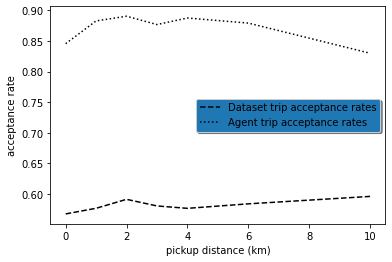

In [19]:
#draw graphs
"""
plt.plot([0]+pickup_distance_brackets, trip_acceptance_rates)
plt.xlabel('pickup distance (km)')
plt.ylabel('acceptance rate')
legned()
plt.show()
"""
# Make some fake data.
a = b = [0]+pickup_distance_brackets
c = pickup_acceptance_rates
d = pickup_acceptance_rates_agent

# Create plots with pre-defined labels.
fig, ax = plt.subplots()
ax.plot(a, c, 'k--', label='Dataset trip acceptance rates')
ax.plot(a, d, 'k:', label='Agent trip acceptance rates')
#ax.plot(a, c + d, 'k', label='Total message length')
plt.xlabel('pickup distance (km)')
plt.ylabel('acceptance rate')
legend = ax.legend(loc='best', shadow=True, fontsize='medium')

# Put a nicer background color on the legend.
legend.get_frame().set_facecolor('C0')

plt.show()

In [20]:
labels = ['0-1', '1-2', '2-3', '3-4', '4-6', '6-10', '10+']
men_means = pickup_acceptance_rates
women_means = pickup_acceptance_rates_agent

men_means = 
women_means = 

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, men_means, width, label='Dataset acceptance rates')
rects2 = ax.bar(x + width/2, women_means, width, label='Agent acceptance rates')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('pickup distance (km)')
ax.set_xlabel('acceptance rate')
ax.set_title('acceptance rate variation with pickup distance')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(fontsize='small')


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


#autolabel(rects1)
#autolabel(rects2)

#fig.tight_layout()

plt.show()

SyntaxError: invalid syntax (<ipython-input-20-0517de92f551>, line 5)

In [16]:
##########################################################################################
















Text(0.5, 0, 'Iterations')

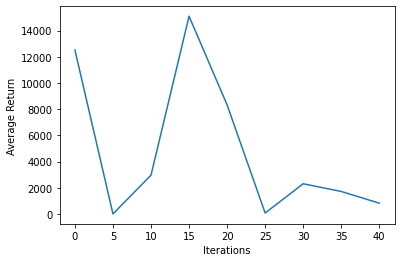

In [22]:
#visualize progress
iterations = range(0, num_iterations +1, eval_interval)
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')
#plt.ylim(top=50000)

In [23]:
#run_simulation(eval_policy)
evaluatePolicy(eval_policy, eval_env)

0
0
0
0
[[ 9.8        31.4        12.         26.11502821  4.54088685 36.        ]]
46.19999999999999
0
[[10.1        31.         21.         40.11121041 14.95609091 34.        ]]
42.849999999999966
0
0
0
0
0
[[ 7.1        33.1        18.         13.77156657  6.87263191 28.        ]]
69.69999999999999
0
0
0
0
0
0
[[ 9.4        36.7         9.         39.90654576 24.68734407 21.        ]]
67.34999999999997
0
[[ 3.2        21.3        10.         41.57807568 15.14456473 19.        ]]
53.75
0
[[ 3.2        25.1        16.         46.15988719 19.26282944 17.        ]]
67.04999999999998
[[10.9        13.         11.         57.02464872  3.33403312 16.        ]]
-25.349999999999994
driver reward  321.54999999999984
[[19.3   21.8   10.    45.439 13.368 40.   ]]
-49.150000000000034
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
[[ 7.6        31.9        16.         49.07398586 19.380283   16.        ]]
62.25
driver reward  13.099999999999966
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
[

0
[[ 8.5        26.7        20.          5.90416529 12.29100013 -1.        ]]
38.19999999999999
0
0
[[13.1   13.2    7.    11.45   0.875 -1.   ]]
-38.94999999999999
0
0
0
0
0
0
0
0
[[16.2        20.5        17.         16.41804474 10.52128281 -1.        ]]
-33.55000000000001
0
0
0
0
0
0
0
0
0
[[ 4.1        26.6        19.         30.08306651 27.60773813 -1.        ]]
66.44999999999999
0
0
0
0
0
0
0
0
0
0
0
[[18.6        37.1        11.         26.67971329 14.41927684 -1.        ]]
8.949999999999989
0
[[ 1.2        21.5        18.         25.44544001 12.87059223 -1.        ]]
67.45000000000002
0
0
[[ 6.8        18.         19.         17.78242559  4.72682448 -1.        ]]
18.799999999999983
0
[[15.         23.         20.         27.81500516 21.75607153 -1.        ]]
-17.0
driver reward  345.3499999999999
0
0
0
0
0
[[ 2.8        32.7        11.         39.08943545 23.61942005 35.        ]]
96.25
0
0
0
0
0
0
0
0
0
0
0
0
0
0
[[ 6.9        40.5        11.         25.27840888 24.04785178 20

<ipython-input-12-ff47d4624acb>:33: RuntimeWarning: invalid value encountered in double_scalars
  hrly_acceptance_rates.append(hrly_accepted_trips[j]/hrly_trip_counts[j])


In [52]:
#evaluate a trained policy with respect to a pre-generated static environment
def evaluateSavedPolicy(policy, policy_state, eval_env):
    episode_reward = 0
    for state_list in eval_env:
        states = []
        driver_reward = 0
        
        for i in range(len(state_list)):
            state_tf = ts.TimeStep(tf.constant([1]), tf.constant(state_list[i]["reward"], dtype=tf.float32), tf.constant([1.0]), tf.convert_to_tensor(np.array([state_list[i]["observation"]], dtype=np.float32), dtype=tf.float32))
            action = policy.action(state_tf, policy_state)

            #action = tf.random.uniform([1], 0, 2, dtype=tf.int32)
            if (action[0].numpy() == 1):
                reward = state_list[i]["reward"]
            else:
                reward = 0
            print (reward)
            driver_reward += reward
        episode_reward += driver_reward
        print("driver reward ", driver_reward)
    print("total reward ", episode_reward)


In [19]:
#load saved policy
saved_policy = tf.compat.v2.saved_model.load('pol/policy_10')
policy_state = saved_policy.get_initial_state(batch_size=3)
"""time_step = ...
while True:
  policy_step = saved_policy.action(time_step, policy_state)
  policy_state = policy_step.state
  time_step = f(policy_step.action)
"""
observations = [8, 10, 0, 35]
#observation_ts = ts.transition(np.array(observations, dtype=np.float32), reward=0.0, discount=1.0)
observation_ts = ts.TimeStep(tf.constant([1]), tf.constant([0.0]), tf.constant([1.0]),
                                tf.convert_to_tensor(np.array([observations], dtype=np.float32), dtype=tf.float32))
action = saved_policy.action(observation_ts, policy_state)
print(action)

OSError: SavedModel file does not exist at: pol/policy_10/{saved_model.pbtxt|saved_model.pb}

In [ ]:
avg_return = compute_avg_return(saved_policy, num_eval_episodes)

In [ ]:
#evaluateSavedPolicy(saved_policy, policy_state, eval_env)
evaluatePolicy(eval_policy, eval_env)

In [ ]:
"""


reward results - 
random policy - around 9.5k
learned policy - 14k
always accept policy - 19.4k
"""

##############################################################################################



In [ ]:
# startup simulation

def simpy_episode(rewards, steps, time_step, tf_env, policy):

    TIME_MULTIPLIER = 50
    DRIVER_COUNT = 1
    TRIP_COUNT = 8000
    RUN_TIME = 10000
    INTERVAL = 20
    # GRID_WIDTH = 3809
    # GRID_HEIGHT = 2622
    GRID_WIDTH = 60
    GRID_HEIGHT = 40
    HEX_AREA = 2.6

    Env = simpy.Environment()
    map_grid = Grid(env=Env, width=GRID_WIDTH, height=GRID_HEIGHT, interval=INTERVAL, num_drivers=DRIVER_COUNT,
                    hex_area=HEX_AREA)

    taxi_spots = map_grid.taxi_spots
    driver_list = create_drivers(Env, DRIVER_COUNT, map_grid)
    driver_pools = map_grid.driver_pools

    run_simulation(TRIP_COUNT, RUN_TIME, DRIVER_COUNT, TIME_MULTIPLIER, map_grid, taxi_spots, driver_list, driver_pools, Env, rewards, steps, time_step, tf_env, policy)
    t_count = 0
    for dr in driver_list:
        d_t_count = dr.total_trip_count
        t_count += d_t_count
        print(f"{dr.id} completed {d_t_count}")

    print(f"Total trip count: {t_count}")

In [ ]:
var = tf.random.uniform([1], 0, 2, dtype=tf.int32)
var[0] = 2
print (var)

In [ ]:
#simple episode run - atttempt 1

time_step = tf_env.reset()
rewards = []
steps = []
num_episodes = 5

for _ in range(num_episodes):
    simpy_episode(rewards, step, time_step, tf_env, policy)

    action = tf.random.uniform([1], 0, 2, dtype=tf.int32)
    time_step = tf_env.step(action)
    episode_steps += 1
    episode_reward += time_step.reward.numpy()
  rewards.append(episode_reward)
  steps.append(episode_steps)
  time_step = tf_env.reset()

num_steps = np.sum(steps)
avg_length = np.mean(steps)
avg_reward = np.mean(rewards)

In [ ]:
#simple episode run - atttempt 2

#time_step = tf_env.reset()
rewards = []
steps = []
num_episodes = 5

for _ in range(num_episodes):
    time_step = tf_env.reset()
    
    
    
    
    
    
    simpy_episode(rewards, step, time_step, tf_env, policy)

    action = tf.random.uniform([1], 0, 2, dtype=tf.int32)
    time_step = tf_env.step(action)
    episode_steps += 1
    episode_reward += time_step.reward.numpy()
  rewards.append(episode_reward)
  steps.append(episode_steps)
  time_step = tf_env.reset()

num_steps = np.sum(steps)
avg_length = np.mean(steps)
avg_reward = np.mean(rewards)

In [3]:
#simple episode run template
"""
time_step = tf_env.reset()
rewards = []
steps = []
num_episodes = 5

for _ in range(num_episodes):
  episode_reward = 0
  episode_steps = 0
  while not time_step.is_last():
    action = tf.random.uniform([1], 0, 2, dtype=tf.int32)
    time_step = tf_env.step(action)
    episode_steps += 1
    episode_reward += time_step.reward.numpy()
  rewards.append(episode_reward)
  steps.append(episode_steps)
  time_step = tf_env.reset()

num_steps = np.sum(steps)
avg_length = np.mean(steps)
avg_reward = np.mean(rewards)

print('num_episodes:', num_episodes, 'num_steps:', num_steps)
print('avg_length', avg_length, 'avg_reward:', avg_reward)
"""

"\ntime_step = tf_env.reset()\nrewards = []\nsteps = []\nnum_episodes = 5\n\nfor _ in range(num_episodes):\n  episode_reward = 0\n  episode_steps = 0\n  while not time_step.is_last():\n    action = tf.random.uniform([1], 0, 2, dtype=tf.int32)\n    time_step = tf_env.step(action)\n    episode_steps += 1\n    episode_reward += time_step.reward.numpy()\n  rewards.append(episode_reward)\n  steps.append(episode_steps)\n  time_step = tf_env.reset()\n\nnum_steps = np.sum(steps)\navg_length = np.mean(steps)\navg_reward = np.mean(rewards)\n\nprint('num_episodes:', num_episodes, 'num_steps:', num_steps)\nprint('avg_length', avg_length, 'avg_reward:', avg_reward)\n"